<a href="https://colab.research.google.com/github/SebastianOrmaechea/Reinforcement-Learning/blob/main/Lab2RL_G_O_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 2: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2022



<font color="black">Integrantes:


<font color="black"> - Ramos, Pablo Nicolás


# Introducción

Créditos:

* Documentación y repo de Stable-baselines https://stable-baselines3.readthedocs.io.
    * Tutorial sobre SB3: https://github.com/araffin/rl-tutorial-jnrr19.
* Documentación y repo de OpenAI Gym https://github.com/openai/gym/blob/master/docs/.
    * Crear un entorno https://github.com/openai/gym/blob/master/docs/creating-environments.md. 

Stable-baselines3: framework de deep RL que provee interfaces para ejecutar y adaptar algoritmos de RL "al estilo scikit-learn". Permite utilizar agentes abstrayéndonos de los detalles de bajo nivel de abstracción referentes a la implementación del algoritmo$^1$

Además, ofrece herramientas muy útiles como

* Monitores que permiten ver el rendimiento del agente según se desempeña en el entorno, sin tener que esperar a que finalice de entrenar.
* Callbacks que permiten accionar eventos cuando se cumplen algunas condiciones en el entrenamiento de nuestro agente (por ejemplo, detenerlo si la recompensa recibida es menor a cierto umbral tras un cierto período de tiempo).


Documentación https://stable-baselines3.readthedocs.io

Es un fork activamente mantenido de [OpenAI baselines](https://github.com/openai/baselines)

La versión 3 cambia el framework subyacente de Tensorflow a Pytorch y está activamente en desarrollo; no obstante la versión 2 es completamente funcional

$^1$ no obstante, al igual que sucede generalmente con librerías de ML: 

* Siempre es bueno tener en mente las características, ventajas y desventajas del algoritmo utilizado, pues de eso depende mucho la convergencia de nuestra solución, especialmente cuando se emplean entornos adaptados para nuestras necesidades. 

* Esta librería, al igual que demás frameworks generales de RL, están muy probadas en entornos estándares de RL como Atari o PyBullet. No obstante, es posible que nuestro entorno o nuestras necesidades difieran significativamente, lo que hace que en algunos casos haya que meter mano directo en el código de los algoritmos/librería.

# Interfaz básica stable-baselines

In [1]:
import time

### Instalación de Stable-baselines


In [2]:
#@title Instalación (no modificar)
!pip install stable-baselines3[extra] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Desde Windows, además, instalar: 
* Microsoft Visual C++ desde https://visualstudio.microsoft.com/visual-cpp-build-tools/
* PyType, mediante `conda install -c conda-forge pytype`

### Instalación de RLBaselinesZoo (Opcional!)

Desde Google Colab

In [3]:
#@title Instalación de RLBaselinesZoo (no modificar)

# Estamos en Colab?

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !git clone --recursive --depth 1 https://github.com/DLR-RM/rl-baselines3-zoo
  !cd rl-baselines3-zoo/
  !apt-get install swig cmake ffmpeg
  !pip install -r /content/rl-baselines3-zoo/requirements.txt

fatal: destination path 'rl-baselines3-zoo' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (4.0.1-5build1).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Desde Linux, ejecutando

    git clone --recursive --depth 1 https://github.com/DLR-RM/rl-baselines3-zoo
    cd rl-baselines3-zoo/
    conda install swig
    pip install -r requirements.txt

## Ejecución de un algoritmo de RL

### Importaciones/inicializaciones

In [4]:
import os
from subprocess import Popen, PIPE

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces
#from gym.envs.registration import register

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_vec_env


%matplotlib inline
%load_ext tensorboard

In [5]:
from google.colab import drive

google_drive = "/content/gdrive"

root_path = os.path.join(google_drive, "My Drive", "diplodatos_optativas", "dl", "tp2")

drive.mount(google_drive, force_remount = True)

Mounted at /content/gdrive


In [6]:
os.makedirs("logs", exist_ok=True)

#cwd = os.getcwd()

cwd = root_path

### Renderización

In [7]:
if not IN_COLAB:

  obs = env.reset()
  for i in range(1000):
      action, _states = model.predict(obs, deterministic=True)
      obs, reward, done, info = env.step(action)
      env.render()
      if done:
        obs = env.reset()

  env.close()

#### Ver rendimiento del agente en tensorboard

In [8]:
venv = make_vec_env(lambda: gym.make("CartPole-v1"), n_envs=1)

model = DQN('MlpPolicy', venv, tensorboard_log="tensorboard/")
model.learn(total_timesteps=100000)

Para verlo en tensorboard, correr

`tensorboard --logdir=tensorboard/`

### Monitor

Vamos a crear un monitor para loguear nuestro agente en la carpeta logs. Nuestro monitor guardará datos de recompensa (r), duración (l) y tiempo total (t)

In [9]:
env = gym.make("CartPole-v1")
env = Monitor(env, "logs/")  # reemplazamos env por su monitor

model = DQN("MlpPolicy", env, )
model.learn(total_timesteps=10000)

### Callbacks

In [10]:
env = gym.make("CartPole-v1")

callbacks = []  # lista de callbacks a usar, pueden ser varios

# callback para detener entrenamiento al alcanzar recompensa de 9.8
# (es una recompensa muy baja, pero la establecemos a fines demostrativos)
# que deje de entrenar a un cierto umbral de recompensa
stop_training_callback = StopTrainingOnRewardThreshold(reward_threshold=9.8)

# al crear EvalCallback, se asocia el mismo con stop_training_callback
callbacks.append(EvalCallback(Monitor(env, 'logs/'), 
                              eval_freq=1000,
                              callback_on_new_best=stop_training_callback))

# la semilla aleatoria hace que las ejecuciones sean determinísticas
model = DQN('MlpPolicy', env, seed=42)
model.learn(total_timesteps=10000, callback=callbacks)

Eval num_timesteps=1000, episode_reward=9.60 +/- 0.80
Episode length: 9.60 +/- 0.80
New best mean reward!
Eval num_timesteps=2000, episode_reward=9.20 +/- 0.75
Episode length: 9.20 +/- 0.75
Eval num_timesteps=3000, episode_reward=9.80 +/- 0.75
Episode length: 9.80 +/- 0.75
New best mean reward!


### Ejecutar agente RL en múltiples ambientes

Esta librería provee una interfaz para ejecutar agentes en varias instancias de un mismo entorno a la vez (*vectorized environments*), de modo tal que se habilite la ejecución paralela y de otras funcionalidades útiles.

Para ello, varios de sus algoritmos implementan cambios que consideren la posibilidad de que haya múltiples entornos subyacentes, por ejemplo `step(accion)` cambia a `step(lista_acciones)`, aplicando acciones a todos los entornos, recibiendo ahora múltiples observaciones y recompensas.

Otro cambio: se aplica `reset()` automáticamente a cada entorno que llega a un estado final.

SB brinda dos formas de utilizar entornos vectorizados:

* **DummyVecEnv**, el cuál consiste en un *wrapper* de varios entornos, los cuáles funcionarán en un sólo hilo. Este wrapper es útil como entrada de algoritmos que requieren los entornos de esta forma, y habilita los procesamientos y operaciones comunes de los entornos vectorizados.
* **SubprocVecEnv**, el cuál paraleliza multiples entornos pero en procesos de ejecucíon separados. Cada proceso tiene su propia memoria y puede adquirir derechos sobre las CPUs de la computadora donde se ejecuta. Se utiliza cuando el entorno del agente es computacionalemente complejo. Atención! **Puede comer mucha RAM**.

Vemos un ejemplo:

In [11]:
# ejemplo de ambiente dummy
venv = DummyVecEnv([lambda: gym.make("CartPole-v1")]*4)

model = PPO("MlpPolicy", venv, )
model.learn(total_timesteps=10000)

También puede hacerse con un una función de SB a tal efecto

In [ ]:
venv = make_vec_env(lambda: env, n_envs=4)

model = PPO('MlpPolicy', venv, )
model.learn(total_timesteps=10000)

### Ejecutar agente con políticas personalizadas

In [12]:
# Creamos una clase con una red neuronal de 128x128 neuronas

model = PPO("MlpPolicy", policy_kwargs=dict(net_arch=[128,128]), env="CartPole-v1", verbose=1)
model.learn(total_timesteps=10000)

Using cuda device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | 22.7     |
| time/              |          |
|    fps             | 811      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 26.6         |
|    ep_rew_mean          | 26.6         |
| time/                   |              |
|    fps                  | 390          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0077837193 |
|    clip_fraction        | 0.0848   

[Buen post](https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2) en donde se explica qué significan varias de estas métricas. Para verlas en detalle podemos consultar directamente el [código fuente](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/ppo/ppo.py), que está bien documentado y no es muy difícil de seguir.

### Utilizar un entorno personalizado

Antes que nada, además de la interfaz que ya vimos de Gym, hay otras nociones que tenemos que tener en cuenta en este contexto:

* Los entornos definen un espacio de estados y de acciones, a partir de los cuáles los modelos asumen y respetan la "forma" de observaciones y acciones. Por ejemplo, algunos algoritmos están diseñados para espacios de acciones discretos (DQN), continuos (DDPG) o bien poseen implementaciones particulares pueden usarse en ambos (PPO, en el repo de SB3). En cuanto a los espacios, algunos algoritmos asumen explícitamente un espacio discreto (y pequeño), como Q-Learning, mientras que otros como PPO asumen cualquier tipo de espacio.
* Los dos tipos más comunes de estados o acciones son los espacios discretos `gym.spaces.Discrete` y los continuos `gym.spaces.Box`.
* Los espacios discretos definen un conjunto de $n$ estados/acciones $\{ 0, 1, \dots, n-1 \}$, mientras que los espacios continuos definen un espacio $\mathbb{R}^d$, de una de las siguientes 4 formas: $[a, b], (-\infty, b], [a, \infty), (-\infty, \infty)$, en donde $a,b$ son las cotas superior e inferior (de existir).
* Ejemplos: un espacio de acciones `Discrete(4)` tiene 4 acciones: $\{0,1,2,3\}$; un espacio de estados `Discrete(16)` tiene 16 estados. Un espacio de estados ALTURA, ANCHO, N_CANALES que represente una imagen RGB acotada en $[a=0, b=255]$ se puede crear como

`observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)`

Para usar un entorno compatible por esta librería, el mismo tiene que heredar de *gym.Env*. Vemos un ejemplo (crédito: Antonin Raffin https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)

In [13]:
class GoLeftEnv(gym.Env):
  #clase heredada de los ambientes de gym
  """
  Ambiente personalizado que sigue la interfaz de gym.
  Es un entorno simple en el cuál el agente debe aprender a ir siempre 
  hacia la izquierda.
  """
  # Dado que podemos estar en colab, no podemos implementar la salida por interfaz 
  # gráfica ('human' render mode) 
  metadata = {'render.modes': ['console']}
  # Definimos las constantes
  LEFT = 0
  RIGHT = 1

  def __init__(self, grid_size=10):
    super(GoLeftEnv, self).__init__()

    # Tamaño de la grilla de 1D
    self.grid_size = grid_size
    # Inicializamos en agente a la derecha de la grilla
    self.agent_pos = grid_size - 1

    # Definimos el espacio de acción y observaciones
    # Los mismos deben ser objetos gym.spaces
    # En este ejemplo usamos dos acciones discretas: izquierda y derecha
    n_actions = 2
    self.action_space = spaces.Discrete(n_actions)
    # La observación será la coordenada donde se encuentra el agente
    # puede ser descrita tanto por los espacios Discrete como Box
    self.observation_space = spaces.Box(low=0, high=self.grid_size,
                                        shape=(2,), dtype=np.float32)

  def reset(self):
    """
    Importante: la observación devuelta debe ser un array de numpy
    :return: (np.array) 
    """
    # Se inicializa el agente a la derecha de la grilla
    self.agent_pos = self.grid_size - 1
    # convertimos con astype a float32 (numpy) para hacer más general el agente
    # (en caso de que querramos usar acciones continuas)
    return np.array([self.agent_pos]).astype(np.float32)

  def step(self, action):
    if action == self.LEFT:
      self.agent_pos -= 1
    elif action == self.RIGHT:
      self.agent_pos += 1
    else:
      raise ValueError("Se recibió una acción inválida={} que no es parte del espacio de acciones".format(action))

    # Evitamos que el agente se salga de los límites de la grilla
    self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size)

    # Llegó el agente a su estado objetivo (izquierda) de la grilla?
    done = bool(self.agent_pos == 0)

    # Asignamos recompensa sólo cuando el agente llega a su objetivo
    # (recompensa = 0 en todos los demás estados)
    reward = 1 if self.agent_pos == 0 else 0

    # gym también nos permite devolver información adicional, ej. en Atari: 
    # las vidas restantes del agente (no usaremos esto por ahora)
    info = {}

    return np.array([self.agent_pos]).astype(np.float32), reward, done, info

  def render(self, mode='console'):
    if mode != 'console':
      raise NotImplementedError()
    # en nuestra interfaz de consola, representamos el agente como una cruz, y 
    # el resto como un punto
    print("." * self.agent_pos, end="")
    print("x", end="")
    print("." * (self.grid_size - self.agent_pos))

  def close(self):
    pass

In [14]:
env = GoLeftEnv(grid_size=10)
env = make_vec_env(lambda: env, n_envs=1)

model = DQN('MlpPolicy', env, verbose=1).learn(20000)

Using cuda device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 76.2     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5003     |
|    time_elapsed     | 0        |
|    total_timesteps  | 305      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5266     |
|    time_elapsed     | 0        |
|    total_timesteps  | 852      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.356    |
| time/               |          |
| 

Ver agente entrenado

In [15]:
obs = env.reset()
for i in range(10):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render(mode='console')
    if dones[0]:
        obs = env.reset()

........x..
.......x...
......x....
.....x.....
....x......
...x.......
..x........
.x.........
.........x.
........x..


## Normalización de features y recompensas

Stable-Baselines3 tiene predefinidos un conjunto de **wrappers** genericos que pueden utilizarse para preprocesar las observaciones que llegan al agente RL, desacoplando del mismo el prepocesamiento.

Entre las funcionalidades disponibles tenemos:
* **VecFrameStack**: Se utiliza cuando la observación que percibe el agente es una imagen. Sirve para expandir el espacio de estados apilando N frames de manera conjunta (ver [paper de DQN](https://arxiv.org/abs/1312.5602) para más detalle).
* **VecNormalize**: Se utiliza para normalizar las observaciónes y/o las recompenzas que percibe el agente, a $\mu=0$ y $\sigma=1$. También permite cortar valores de observaciones y/o recompensas que excedan un rango establecido. 
* **VecCheckNan**: Se utiliza para trackear los estados del entorno que generan que los gradientes de la RNN se hagan NaN.
* **VecVideoRecorder**: Se utiliza para exportar el funcionamiento de la política aprendida por el agente a un video (MP4).

Ademas, se pueden crear **wrappers** personalizados extendiendo la clase **VecEnvWrapper**:

```
class MiWrapper(VecEnvWrapper):
    [...]
```
### Ejemplo (VecNormalize)

In [16]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

env = gym.make('CartPole-v1')
env = DummyVecEnv([lambda: env])  # Multiples entornos vectorizados
# Normalizamos tanto observaciones como recompensas, y recortamos ambas cuando exceden 10
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0)

model = DQN('MlpPolicy', env)
model.learn(total_timesteps=10000)


# RL-baselines3-zoo

Colección de agentes RL y herramientas útiles para ejecutarlos, evaluarlos e incluso hacer videos con ellos. Los agentes de este repo están preparados con la configuración requerida para los distintos tipos de entornos, incluyendo Atari, PyBullet y entornos clásicos, incluyendo configuraciones e híper-parámetros que producen buenas políticas para tales entornos.

Esta librería ofrece un muy buen punto de partida para utilizar agentes / entornos personalizados, ya que ofrece una [interfaz](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/train.py) fácilmente adaptable a nuestras necesidades.

Si se usan entornos personalizados con rl-baselines3-zoo, debe tenerse en cuenta que se deben definir todos los híper-parámetros de antemano, sea al instanciar el agente, o en la carpeta */rl-baselines3-zoo/hyperparams*; de lo contrario arrojará error por no encontrar qué híper-parámetro usar.

**Importante:** esta librería es enteramente opcional, no es necesaria para realizar los labs.

In [17]:
# verificamos si está el repo rl-baselines3-zoo, si es así ejecutamos las celdas siguientes
repo_downloaded = os.path.exists('rl-baselines3-zoo')

## Ejecución

Los agentes pueden ser llamados desde la consola mediante comandos como

`python train.py --algo algo_name --env env_id`

Los cuales pueden ser llamados usando

In [18]:
if repo_downloaded:

    os.chdir('rl-baselines3-zoo/')

    args = [
        '-n', str(100000),
        '--algo', 'ppo',
        '--env', 'CartPole-v1'
    ]

    p = Popen(['python', 'train.py'] + args,
                                   stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    rc = p.returncode
    os.chdir(cwd)
    assert rc == 0

Ver en acción el agente entrenado (nota: no disponible en Google Colab, requiere ffmpeg)

In [19]:
if not IN_COLAB and repo_downloaded:
    os.chdir('rl-baselines3-zoo/')

    args = [
        '--algo', 'ppo',
        '--env', 'CartPole-v1',
        '--folder', 'logs/'
    ]

    p = Popen(['python', 'enjoy.py'] + args,
                                   stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    rc = p.returncode
    os.chdir(cwd)
    assert rc == 0

También es posible grabar un video! Ver https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#record-a-video

Ver curva de aprendizaje obtenida por el agente desde *utils.plot*

In [ ]:
os.chdir('rl-baselines3-zoo/')

args = [
    '--algo', 'ppo',
    '--env', 'CartPole-v1',
    '--exp-folder', 'logs/'
]

p = Popen(['python', '-m', 'scripts.plot_train'] + args, stdout=PIPE)
output, err = p.communicate()
rc = p.returncode
os.chdir(cwd)

assert rc == 0

In [20]:
print(output)

b"========== CartPole-v1 ==========\nSeed: 3772482767\nLoading hyperparameters from: /content/rl-baselines3-zoo/hyperparams/ppo.yml\nDefault hyperparameters for environment (ones being tuned will be overridden):\nOrderedDict([('batch_size', 256),\n             ('clip_range', 'lin_0.2'),\n             ('ent_coef', 0.0),\n             ('gae_lambda', 0.8),\n             ('gamma', 0.98),\n             ('learning_rate', 'lin_0.001'),\n             ('n_envs', 8),\n             ('n_epochs', 20),\n             ('n_steps', 32),\n             ('n_timesteps', 100000.0),\n             ('policy', 'MlpPolicy')])\nUsing 8 environments\nOverwriting n_timesteps with n=100000\nCreating test environment\nUsing cuda device\nLog path: logs/ppo/CartPole-v1_2\n---------------------------------\n| rollout/           |          |\n|    ep_len_mean     | 17.2     |\n|    ep_rew_mean     | 17.2     |\n| time/              |          |\n|    fps             | 289      |\n|    iterations      | 1        |\n|    ti

## Híper-parámetros

rl-baselines-zoo provee híper-parámetros que resultan en curvas de aprendizaje que convergen en buena cantidad de entornos. Estos híper-parámetros pueden verse en cada uno de los archivos YAML de cada algoritmo, [acá](https://github.com/DLR-RM/rl-baselines3-zoo/tree/master/hyperparams).

También provee funcionalidad para optimizar los híper-parámetros con la librería [Optuna]( https://github.com/optuna/optuna). En los mismos se incluyen rangos de híper-parámetros que se usaron para optimizar entornos como los de PyBullet, y son fácilmente modificables para adaptarlo a nuestros propios entornos. Para ver cómo se llama a la interfaz de Optuna ver [este código](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/utils/hyperparams_opt.py).

Nota: **Optuna come muchos recursos!**

# Entrenando otros agentes

### Algunos conjuntos de entornos

CartPole es una excelente línea base (de hecho suele ser la prueba preliminar de todo nuevo algoritmo), porque tiene recompensas constantes pero requiere cierta solidez por parte del algoritmo para hacerlo converger al óptimo.

No obstante, al implementar un algoritmo, es deseable que el mismo pueda desenvolverse de forma consistente en varios grupos de entornos. A continuación va una lista con varios entornos que sirven como prueba:

| Entornos                                                                                                           | Estados            | Acciones            | Dificultad      | Implementado por                                                                                                                                                            |
|--------------------------------------------------------------------------------------------------------------------|--------------------|---------------------|-----------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Clásicos (CartPole, MountainCar, Pendulum, Deep sea (testea exploración), umbrella (testea asignación de crédito)) | Discretos/Continuos          | Continuas/discretas | Baja/Media      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments) y [BSuite](https://github.com/deepmind/bsuite)                                                                                                                          |
| Grilla (desde pequeñas donde hay que salir hasta grandes con muchas habitaciones y subproblemas)                   | Discretos/imágenes | Discretas           | Baja/Media/Alta | [gym-minigrid](https://github.com/maximecb/gym-minigrid)                                                                                                                    |
| Grilla/plataforma/estilo Atari, generados proceduralmente                                                          | Imágenes           | Discretas           | Media/Alta      | [Gym](https://github.com/openai/procgen)                                                                                                                                    |
| Plataforma 2D, como LunarLander o BipedalWalker                                                                    | Continuos          | Continuas/discretas | Media/Alta      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments)                                                                                                                                                                         |
| Primera persona en 3D                                                                                              | Imágenes           | Continuas/discretas | Media/Alta      | [Deepmind](https://github.com/deepmind/lab)                                                                                                                                 |
| Simulación física de pequeños robots                                                                               | Continuos          | Continuas           | Media/Alta      | Gym (con el motor [MuJoCo](https://mujoco.org/) o [PyBullet](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.wz5to0x8kqmr)) |
| Atari                                                                                                              | Continuos          | Discretas           | Media/Alta      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments) (son todos aquellos entornos que terminan en "*-v4*"                                                                                                                                                                         |


## Resumen de algunos algoritmos

Se resumen ahora varios algoritmos del estado del arte de aprendizaje por refuerzos profundo



| Algoritmo | Tipo       | Espacio de acciones | Resumen rápido                                                                                                                                                | Artículo                         |
|-----------|------------|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------|
| DQN       | Off-policy | Discretas           | Extiende Q-Learning a deep learning. En Stable-baselines, DQN incluye todas las mejoras ya incorporadas.                                                      | https://arxiv.org/abs/1312.5602  |
| ACER      | Off-policy | Discretas           | Combina una arquitectura actor-critic con un buffer y repetición de experiencia.                                                                              | https://arxiv.org/abs/1611.01224 |
| A3C       | On-policy  | Ambos               | Múltiples agentes corriendo en múltiples instancias del ambiente, acumulando sus gradientes y actualizándolos tras un cierto tiempo.                          | https://arxiv.org/abs/1602.01783 |
| PPO       | On-policy  | Ambos               | Punta de lanza de policy gradient, incluye mecanismo para que el gradiente actualice de forma acotada, mejorando drásticamente la estabilidad.             | https://arxiv.org/abs/1707.06347 |
| DDPG      | Off-policy | Continuas           | Como en espacios de acciones continuos es muy difícil encontrar $\max_a Q(s,a)$, se aproxima via $Q(s, a(s \mid \theta_a))$, siendo $a$ un actor estocástico. | https://arxiv.org/abs/1509.02971 |
| TD3       | Off-policy | Continuas           | Mejora DDPG utilizando dos funciones $Q$ y retrasando la actualización para reducir la sobreestimación de $Q$.                                                | https://arxiv.org/abs/1802.09477 |
| SAC       | Off-policy | Continuas           | Usa dos funciones $Q$, introduce el bonus por entropía y usa un actor estocástico que muestrea acciones según una política $\pi$.                             | https://arxiv.org/abs/1801.01290 |

## Resumen de algunas herramientas/trucos comúnmente usados

* Experience replay/buffer de experiencia: guarda las experiencias en un buffer para poder usarlas repetidamente durante el entrenamiento.
    * Ventajas: experiencias raras pero muy relevantes (ej: que tienen mucho error de actualización) quedan guardadas en memoria, pudiendo ser usadas repetidamente para aprender sin necesidad de esperar a que se repitan.
    
    En métodos de gradiente de política, en cambio, el aprendizaje queda reflejado en los pesos, lo cuál puede hacer que un agente no se desenvuelva correctamente en entornos de recompensa escasa como MountainCar.
    
    * Desventajas: requiere considerable RAM, son usables solamente en algoritmos off-policy y su muestreo no necesariamente refleja la probabilidad real de tener esas experiencias en el entorno (añadiendo sesgo), por lo que es recomendable usarlo junto con importance sampling.
    
* Importance sampling: aplica un descuento a las actualizaciones a partir de experience replay relacionado a cuán probable era realizar esa transición.
* Entropía: añade un bonus a la función de recompensa para que bonifique políticas $\pi(s \mid a)$ que tengan mayor entropía que otras, motivando la exploración del agente.
* Juntar varias secuencias de imágenes. Usado principalmente en entornos de Atari para poder evaluar la dirección de movimientos.
* Normalización de recompensas/estados. Normaliza las recompensas y observaciones usualmente con una media móvil, de modo tal que las observaciones/recompensas reflejen su relación y varianza con respecto a las demás.
* Clipping (recorte) de recompensas. Se usaba principalmente en entornos de Atari con algoritmos tipo DQN para recortar el impacto que las distintas recompensas tenían, a una constante (ej: 1). Suele usarse como una cota máxima de recompensas/observaciones normalizadas.

# Lab 2

1. Crear tu propio entorno y entrenar agentes RL en el mismo. Analizar la convergencia con distintos algoritmos* (ej: PPO, DQN), resultados con distintas funciones de recompensa e híper-parámetros. 

    Algunas ideas:

    * Transformar GoLeftEnv en una grilla 2D, añadir paredes / trampas / agua.
    * Crear un entorno que juegue a algún juego como el ta-te-ti.
    * Crea un entorno totalmente nuevo que sea de tu interés!


# TA TE TI

Este es el juego del TATETI hecho con Python utilizando la biblioteca PyGame y la biblioteca Gym para implementar la IA. En este juego puedes jugar contra la IA que he creado usando Gym libray y StableBaselines3



In [21]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
%matplotlib inline    

In [22]:
!pip install more-itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from gym.spaces import Dict, Discrete, Box, Tuple
from gym import spaces
import random

lista = [i for i in range(0, 9)]

class TaTeTiEnv(gym.Env):

  metadata = {'render.modes': ['console']}
  # Definimos las constantes
  # Cada posicion representa un lugar de un vector de una dimensión
  POSICION0=0
  POSICION1=1
  POSICION2=2
  POSICION3=3
  POSICION4=4
  POSICION5=5
  POSICION6=6
  POSICION7=7
  POSICION8=8



  def __init__(self):
    # Para saber si jugó cierta posición o no
    self.JUGADO0=False
    self.JUGADO1=False
    self.JUGADO2=False
    self.JUGADO3=False
    self.JUGADO4=False
    self.JUGADO5=False
    self.JUGADO6=False
    self.JUGADO7=False
    self.JUGADO8=False
    # Si es el turno o no del adversario
    self.turno=True
    # Lista para jugar un número random, para simular un adversario
    self.lista = [i for i in range(0, 9)]
    self.action_space = Discrete(9)
    self.observation_space = Box(low=np.zeros(9), high=np.ones(9))
    # estado inicial, 0 nadie jugó, 1 jugó el CPU y 2 el adversario simulado
    self.state = [0 for i in range(0, 9)]
    

  def reset(self):
    # Reinicio los estados para poner puede jugar de nuevo
    self.JUGADO0=False
    self.JUGADO1=False
    self.JUGADO2=False
    self.JUGADO3=False
    self.JUGADO4=False
    self.JUGADO5=False
    self.JUGADO6=False
    self.JUGADO7=False
    self.JUGADO8=False
    # seteo el estado todo en cero de nuevo
    self.state = [0 for i in range(0, 9)]

    # acá simulo que al comienzo 1 vez si y una vez no, un adversario
    # imaginario juegue random un movimiento
    if self.turno:

      self.jugar_random()

    self.turno = not self.turno
    return np.array([self.state]).astype(np.float32)

  def jugar_random(self):
    # Acá simulo una posicion random, mirando si ya tiene algo la casilla,
    # en donde juega, sino, juega otra y así
    indices = [0 for i in range(0, 9)]
    random.shuffle(indices)
    indices
    for index in indices:
      if self.state[index]==0:
        self.state[index]=2
        if index==0:
          self.JUGADO0==True
        if index==1:
          self.JUGADO1==True
        if index==2:
          self.JUGADO2==True
        if index==3:
          self.JUGADO3==True
        if index==4:
          self.JUGADO4==True
        if index==5:
          self.JUGADO5==True
        if index==6:
          self.JUGADO6==True
        if index==7:
          self.JUGADO7==True
        if index==8:
          self.JUGADO8==True
        break

  def step(self, action):
    # Me fijo la accion que ejecuta, y si no es su su turno y si la está 
    # ocupada la casilla por el adversario lo penalizo
    reward=0
    if action==0 and self.state[0]==2 and self.JUGADO0==False:
      self.JUGADO0==True
      reward= reward-100
    if action==1  and self.state[1]==2 and self.JUGADO1==False:
      self.JUGADO1==True
      reward= reward-100
    if action==2 and self.state[2]==2 and self.JUGADO2==False:
      self.JUGADO2==True
      reward= reward-100
    if action==3 and self.state[3]==2 and self.JUGADO3==False:
      self.JUGADO3==True
      reward= reward-100
    if action==4 and self.state[4]==2 and self.JUGADO4==False:
      self.JUGADO4==True
      reward= reward-100
    if action==5 and self.state[5]==2 and self.JUGADO5==False:
      self.JUGADO5==True
      reward= reward-100
    if action==6 and self.state[6]==2 and self.JUGADO6==False:
      self.JUGADO6==True
      reward= reward-100
    if action==7 and self.state[7]==2 and self.JUGADO7==False:
      self.JUGADO7==True
      reward= reward-100
    if action==8 and self.state[8]==2 and self.JUGADO8==False:
      self.JUGADO8==True
      reward= reward-100

    # si juega bien que se actualize el estado y que juege random el adversario
    if action == self.POSICION0 and self.state[0]==0 and self.JUGADO0==False:
      self.state[0] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO0=True
    if action == self.POSICION1 and self.state[1]==0 and self.JUGADO1==False:
      self.state[1] = 1
      if not self.check_win():
        self.jugar_random()    
      self.JUGADO1=True
    if action == self.POSICION2 and self.state[2]==0 and self.JUGADO2==False:
      self.state[2] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO2=True
    if action == self.POSICION3 and self.state[3]==0 and self.JUGADO3==False:
      self.state[3] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO3=True
    if action == self.POSICION4 and self.state[4]==0 and self.JUGADO4==False:
      self.state[4] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO4=True
    if action == self.POSICION5 and self.state[5]==0 and self.JUGADO5==False:
      self.state[5] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO5=True
    if action == self.POSICION6 and self.state[6]==0 and self.JUGADO6==False:
      self.state[6] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO6=True
    if action == self.POSICION7 and self.state[7]==0 and self.JUGADO7==False:
      self.state[7] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO7=True
    if action == self.POSICION8 and self.state[8]==0 and self.JUGADO8==False:
      self.state[8] = 1
      if not self.check_win():
        self.jugar_random()
      self.JUGADO8=True


    # si ya jugó y juega de nuevo el mismo lugar, lo penalizo, para que aprenda
  
    if self.JUGADO0 and action==0:
      reward = reward-100
    if self.JUGADO1 and action==1:
      reward = reward-100
    if self.JUGADO2 and action==2:
      reward = reward-100
    if self.JUGADO3 and action==3:
      reward = reward-100
    if self.JUGADO4 and action==4:
      reward = reward-100
    if self.JUGADO5 and action==5:
      reward = reward-100
    if self.JUGADO6 and action==6:
      reward = reward-100
    if self.JUGADO7 and action==7:
      reward = reward-100
    if self.JUGADO8 and action==8:
      reward = reward-100

    #Si gana lo recompensamos
    if self.check_win():
      reward = reward + 1000
      done=True
    else: 
      pass
    # Si pierde lo penalizamos
    if self.check_lose():
      reward = reward -1000
      done=True
    else: 
      pass

    # Si empata, lo penalizo, para que aprenda que esta mal
    if self.check_draw():
      reward = reward -100
      done=True
    else: 
      pass

    # me dijo los estados para terminar o no
    if self.check_win() or self.check_win() or self.check_draw():
      done= True
    else:
      done=False


    info = {}

    return np.array([self.state]).astype(np.float32), reward, done, info

  def check_win(self):
    #filas
    if self.state[0]==1 and self.state[1]==1 and self.state[2]==1:
      return True
    if self.state[3]==1 and self.state[4]==1 and self.state[5]==1:
      return True
    if self.state[6]==1 and self.state[7]==1 and self.state[8]==1:
      return True
    #columnas
    if self.state[0]==1 and self.state[3]==1 and self.state[6]==1:
      return True
    if self.state[1]==1 and self.state[4]==1 and self.state[7]==1:
      return True
    if self.state[2]==1 and self.state[5]==1 and self.state[8]==1:
      return True
    #diagonal
    if self.state[0]==1 and self.state[4]==1 and self.state[8]==1:
      return True
    if self.state[2]==1 and self.state[4]==1 and self.state[6]==1:
      return True
    else:
      return False

  def check_lose(self):
    #filas
    if self.state[0]==2 and self.state[1]==2 and self.state[2]==2:
      return True
    if self.state[3]==2 and self.state[4]==2 and self.state[5]==2:
      return True
    if self.state[6]==2 and self.state[7]==2 and self.state[8]==2:
      return True
    #columnas
    if self.state[0]==2 and self.state[3]==2 and self.state[6]==2:
      return True
    if self.state[1]==2 and self.state[4]==2 and self.state[7]==2:
      return True
    if self.state[2]==2 and self.state[5]==2 and self.state[8]==2:
      return True
    #diagonal
    if self.state[0]==2 and self.state[4]==2 and self.state[8]==2:
      return True
    if self.state[2]==2 and self.state[4]==2 and self.state[6]==2:
      return True
    else:
      return False
    
  def check_draw(self):
    draw = False
    contador=0
    for i in range(0, 9):
      if self.state[i]!=0:
        contador +=1
    
    if contador==9:
      draw = True
    
    return draw

  def render(self, mode='console'):
    if mode != 'console':
      raise NotImplementedError()
    # en nuestra interfaz de consola, representamos el agente como una cruz, y 
    # el resto como un punto
    for i in range(0,9,3):
      if i==0:
        print(f"{self.state[i]} {self.state[i+1]} {self.state[i+2]} ")
      if i==3:
        print(f"{self.state[i]} {self.state[i+1]} {self.state[i+2]} ")
      if i==6:
        print(f"{self.state[i]} {self.state[i+1]} {self.state[i+2]} ")

  def close(self):
    pass

!pip uninstall gym-tictactoe

In [24]:
env = TaTeTiEnv()
env = make_vec_env(lambda: env, n_envs=1)
model = PPO('MlpPolicy', env, verbose=1).learn(20000)

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.92     |
|    ep_rew_mean     | 208      |
| time/              |          |
|    fps             | 488      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.03         |
|    ep_rew_mean          | 297          |
| time/                   |              |
|    fps                  | 257          |
|    iterations           | 2            |
|    time_elapsed         | 15           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0106564555 |
|    clip_fraction        | 0.085        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.19        |
|    explained_variance   | -0.000142   

In [25]:
# Se guarda el modelo obtenido
model.save(os.path.join(root_path, "model", "PPO5millonesFinal"))

# Ver agente entrenado

Se realiza una pequeña demostración de como el agente se desempeña a lo largo de 100 acciones.

In [26]:
env = TaTeTiEnv()
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs)
    print(action)
    obs, rewards, dones, info = env.step(action)
    env.render(mode='console')
    #print(dones)
    if dones:
        obs = env.reset()
    print("-----------")     

[2]
2 0 1 
0 0 0 
0 0 0 
-----------
[2]
2 0 1 
0 0 0 
0 0 0 
-----------
[2]
2 0 1 
0 0 0 
0 0 0 
-----------
[6]
2 0 1 
0 0 0 
1 0 0 
-----------
[2]
2 0 1 
0 0 0 
1 0 0 
-----------
[5]
2 0 1 
0 0 1 
1 0 0 
-----------
[4]
2 0 1 
0 1 1 
1 0 0 
-----------
[5]
2 0 0 
0 0 1 
0 0 0 
-----------
[7]
2 0 0 
0 0 1 
0 1 0 
-----------
[4]
2 0 0 
0 1 1 
0 1 0 
-----------
[4]
2 0 0 
0 1 1 
0 1 0 
-----------
[8]
2 0 0 
0 1 1 
0 1 1 
-----------
[3]
2 0 0 
1 1 1 
0 1 1 
-----------
[6]
2 0 0 
0 0 0 
1 0 0 
-----------
[2]
2 0 1 
0 0 0 
1 0 0 
-----------
[4]
2 0 1 
0 1 0 
1 0 0 
-----------
[4]
2 0 0 
0 1 0 
0 0 0 
-----------
[5]
2 0 0 
0 1 1 
0 0 0 
-----------
[2]
2 0 1 
0 1 1 
0 0 0 
-----------
[5]
2 0 1 
0 1 1 
0 0 0 
-----------
[4]
2 0 1 
0 1 1 
0 0 0 
-----------
[5]
2 0 1 
0 1 1 
0 0 0 
-----------
[1]
2 1 1 
0 1 1 
0 0 0 
-----------
[2]
2 1 1 
0 1 1 
0 0 0 
-----------
[2]
2 1 1 
0 1 1 
0 0 0 
-----------
[3]
2 1 1 
1 1 1 
0 0 0 
-----------
[3]
2 0 0 
1 0 0 
0 0 0 
-----------
[

In [27]:
env = TaTeTiEnv()
obs = [0 for i in range(0, 9)]

for i in range(6):
    action, _states = model.predict(obs)
    print(action)
    obs, rewards, dones, info = env.step(action)
    env.render(mode='console')
    #print(dones)
    if dones:
        obs = env.reset()
    print("-----------")

4
2 0 0 
0 1 0 
0 0 0 
-----------
[1]
2 1 0 
0 1 0 
0 0 0 
-----------
[2]
2 1 1 
0 1 0 
0 0 0 
-----------
[8]
2 1 1 
0 1 0 
0 0 1 
-----------
[5]
2 1 1 
0 1 1 
0 0 1 
-----------
[1]
2 1 0 
0 0 0 
0 0 0 
-----------


/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


# Trabajo Futuro:

Reescribir el código, optimizandolo y en vez de usar listas y muchas variables, usar sólo arreglos y operaciones de Numpy.

Por ejemplo:



```
def is_winning(self, curr_state):
        """Takes state as an input and returns whether any row, column or diagonal has winning sum
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan]
        Output = False"""
        state = np.reshape(curr_state, (3, 3))
        along_axis = (15.0 in np.concatenate(
            (np.nansum(state, axis=1), np.nansum(state, axis=0))))

        return ((np.trace(state) == 15.0)
                or (np.trace(np.fliplr(state)) == 15.0) or (along_axis))
```



# Conclusión:

El agente entrenado, con las grillas y sus movimientos permitió ver si realmente el algoritmo hacía lo que se supone que debía hacer.

El modelo busca el centro cada vez que juega, incluso si no el oponente no juega el centro.


# 2. Entrena agentes en entornos más complejos con stable-baselines/rl-baselines-zoo. Tener en cuenta:

    * Google Colab tiene una limitante en cuanto a cantidad de recursos de CPU/GPU (incluido un "rendimiento decreciente silencioso"), lo cuál reduce la capacidad de entrenar distintos entornos.
    * Si el entorno no está implementado en stable-baselines, debe hacerse un wrapper a mano, lo que puede ser sencillo o puede llevar algo más de trabajo, teniendo que tocar código subyacente de la librería. 

\* pueden ser usando los agentes de stable-baselines, de rl-baselines-zoo, o bien utilizando algún otro algoritmo (incluso tabular)

## **Agente LunarLander**

Entrenamos el agente LunarLander con el objetivo de controlar una nave espacial para aterrizarla de manera segura en la superficie lunar.
El agente toma decisiones sobre qué acciones ejecutar en cada momento. Esto implica evaluar el estado actual de la simulación y seleccionar la acción que maximice la recompensa esperada en el futuro. A medida que el agente experimenta y juega el juego repetidamente, debería ser capaz de aprender a aterrizar la nave de manera más eficiente y segura.



### Configuramos entorno y algoritmo DQN.

In [28]:
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet
!pip install pyglet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.0/831.0 KB 13.1 MB/s eta 0:00:00


In [30]:
# Importamos librerías necesarias
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

In [31]:
# Se configura la red neuronal
nn_layers = [64, 64]

learning_rate = 0.001

In [32]:
# Crea el entorno del agente
env = gym.make('LunarLander-v2')

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = stable_baselines3.common.monitor.Monitor(env, log_dir )
# Inicia la grabación del video
#env.start_video_recorder('video.mp4', (800, 600))

callback = EvalCallback(env,log_path = log_dir, deterministic=True)
policy_kwargs = dict(
    activation_fn=torch.nn.ReLU,
    net_arch=nn_layers
)
model = DQN(
    "MlpPolicy", 
    env,
    policy_kwargs = policy_kwargs,
    learning_rate=learning_rate,
    batch_size=1,  
    buffer_size=1, 
    learning_starts=1, 
    gamma=0.99, #
    tau = 1,  
    target_update_interval=1, 
    train_freq=(1,"step"),
    max_grad_norm = 10, 
    exploration_initial_eps = 1,
    exploration_fraction = 0.5,
    gradient_steps = 1, 
    seed = 1,
    verbose=0
)


In [33]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)

Eval num_timesteps=10000, episode_reward=-741.94 +/- 113.70
Episode length: 121.00 +/- 8.60
New best mean reward!
Eval num_timesteps=20000, episode_reward=-142.47 +/- 50.23
Episode length: 281.80 +/- 90.48
New best mean reward!
Eval num_timesteps=30000, episode_reward=-248.37 +/- 125.25
Episode length: 484.40 +/- 281.96
Eval num_timesteps=40000, episode_reward=-71.69 +/- 22.26
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=-89.86 +/- 39.21
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=38.05 +/- 109.63
Episode length: 578.80 +/- 353.56
New best mean reward!
Eval num_timesteps=70000, episode_reward=45.91 +/- 121.02
Episode length: 613.00 +/- 262.85
New best mean reward!
Eval num_timesteps=80000, episode_reward=112.39 +/- 82.36
Episode length: 720.20 +/- 342.68
New best mean reward!
Eval num_timesteps=90000, episode_reward=216.00 +/- 60.85
Episode length: 525.80 +/- 237.97
New best mean reward!
Eval num_timesteps

### Se grafica el reward para cada episodio

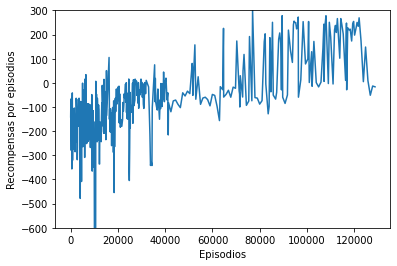

In [34]:
x, y = ts2xy(load_results(log_dir), "timesteps")
plt.plot(x,y)
plt.ylim([-600, 300])
plt.xlabel('Episodios')
plt.ylabel('Recompensas por episodios');

In [ ]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import base64

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env